In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from time import time
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
wd = 'My Drive/CV_Project/'

with open(os.path.join(wd, 'train_img_id_comments.pkl'),'rb') as f:
  train = pickle.load(f)

with open(os.path.join(wd, 'train_img_encoding.pkl'),'rb') as f:
  train_img_encoding = pickle.load(f)

with open(os.path.join(wd, 'val_img_id_comments.pkl'),'rb') as f:
  val = pickle.load(f)

with open(os.path.join(wd, 'val_img_encoding.pkl'),'rb') as f:
  val_img_encoding = pickle.load(f)

with open(os.path.join(wd, 'test_img_id_comments.pkl'),'rb') as f:
  test = pickle.load(f)

with open(os.path.join(wd, 'test_img_encoding.pkl'),'rb') as f:
  test_img_encoding = pickle.load(f)

In [ ]:
#adding startsequence and end sequence tokens before and after each caption of train set
for id in tqdm(train.keys()):
  comments = train[id]
  t = []
  for comment in comments:
    c = '<s> ' + comment + ' </s>'
    t.append(c)

  train[id] = t

100%|██████████| 20340/20340 [00:00<00:00, 433096.14it/s]


In [ ]:
train_images = list(train_img_encoding.keys())
train[train_images[100]]

['<s> two indian students looking at book with adults beside them </s>',
 '<s> indian students working and in discussion in classroom </s>',
 '<s> two darkhaired dark complected talking </s>',
 '<s> two indian women treading to each other </s>',
 '<s> four indian people in classroom </s>']

#### Building vocabulary

In [ ]:
vocab = {}
for id in train.keys():
    comments = train[id]
    for comment in comments:
        words = comment.split(' ')
        for word in words:
            vocab[word] = vocab.get(word, 0) + 1
                
print ("Number of unique words in train corpus = %d" %(len(vocab.keys())))

Number of unique words in train corpus = 16508


Since the number of unique words is too large, we consider only those words which have over 30 occurences. 

In [ ]:
words = [word for word in vocab.keys() if vocab[word]>30]
len(words)

2199

In [ ]:
vocab_words = set(words)
#vocab_words.add('<unk>') #token for out vocabulary word
vocab_words.add('<pad>') #token for padding word
print (len(vocab_words)) 

2200


In [ ]:
word2idx = {}
idx2word = {}

word2idx['<pad>'] = 0
idx2word[0] = '<pad>'

idx = 1
for word in vocab_words :
  if word!='<pad>':
    word2idx[word] = idx
    idx2word[idx] = word
    idx+=1


In [ ]:
max_len = 0
comment_lengths = []

for img_id in tqdm(train.keys()):
    for comment in train[img_id]:
        l = len(comment.split(' '))
        if l>max_len:
            max_len = l
        comment_lengths.append(l)
        
max_len

100%|██████████| 20340/20340 [00:00<00:00, 193611.82it/s]


70

### Building data generator

The model will be predicting one word of the caption at a time given the previous words upto that time for the caption and the image encoding as the input. As each image has 5 captions, atleast 5-6 words per caption and there are around 20K train images, the data won't fit in memory while training. So, the data has to be loaded in batches and for that a generator function is needed.

In [ ]:

vocab_size = len(word2idx)

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(data, attribute_vec, word2idx, max_len, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in data.items():
            n+=1
            # retrieve the image feature vector
            photo = attribute_vec[key]
            for desc in desc_list:
                # encode the sequence
                seq = [word2idx[word] for word in desc.split(' ') if word in word2idx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
datagen = data_generator(train, train_img_encoding, word2idx, max_len, num_photos_per_batch=1)

In [ ]:
X, target_word = next(datagen)
img_encoding = X[0]
partial_caption = X[1]
print (img_encoding.shape, partial_caption.shape, target_word.shape)

(38, 2048) (38, 70) (38, 2200)


### Word Embedding

In [ ]:

embeddings_index = {} # empty dictionary
f = open(os.path.join(wd, 'glove.6B.100d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

In [ ]:
embedding_dim = 100
vocab_size = len(word2idx)
# Get 100-dim dense vector for each of the words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

### Model Architecture

In [ ]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
# partial caption sequence model
inputs2 = Input(shape=(max_len,))

fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 70, 100)      220000      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

Freezing the weights of Embedding layer as we don't want to retrain our word embeddings

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Training
Training on a subset of the training set

Subset size = 2000 images

In [ ]:
subset_size = 100
sample_train = {}
for img in train_images[:subset_size]:
  sample_train[img] = train[img]

In [ ]:
epochs = 10
number_pics_per_batch = 30
steps = len(sample_train)//number_pics_per_batch

In [ ]:
generator = data_generator(sample_train, train_img_encoding, word2idx, max_len, number_pics_per_batch)
losses = []
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    avg_loss_batches = 0
    n_batches = 0
    for batch_id in range(steps):
      n_batches+=1
      print ("Batch", (batch_id+1))
      X,y = next(generator)
      print (y.shape)
      history = model.fit(X,y)
      loss  = history.history['loss'][0]
      avg_loss_batches += loss
      batches += number_pics_per_batch
      if batches >= len(sample_train):
        break

    avg_loss_batches/= n_batches
    losses.append(avg_loss_batches)

Epoch 0
Batch 1
(1674, 2200)
53/53 [==============================] - 11s 146ms/step - loss: 6.5103
Batch 2
(1668, 2200)
53/53 [==============================] - 8s 157ms/step - loss: 5.6687
Batch 3
(1687, 2200)
53/53 [==============================] - 8s 155ms/step - loss: 5.6188
Epoch 1
Batch 1
(1731, 2200)
55/55 [==============================] - 8s 148ms/step - loss: 5.1053
Batch 2
(1670, 2200)
53/53 [==============================] - 8s 148ms/step - loss: 4.9401
Batch 3
(1645, 2200)
52/52 [==============================] - 8s 149ms/step - loss: 5.0111
Epoch 2
Batch 1
(1699, 2200)
54/54 [==============================] - 8s 147ms/step - loss: 4.7249
Batch 2
(1673, 2200)
53/53 [==============================] - 8s 152ms/step - loss: 4.4693
Batch 3
(1694, 2200)
53/53 [==============================] - 8s 152ms/step - loss: 4.6130
Epoch 3
Batch 1
(1683, 2200)
53/53 [==============================] - 8s 152ms/step - loss: 4.4309
Batch 2
(1674, 2200)
53/53 [=============================

In [ ]:
# save model
model_checkpoint = os.path.join(wd, 'model_30_per_batch_100_train')
model.save(model_checkpoint)

INFO:tensorflow:Assets written to: My Drive/CV_Project/model_30_per_batch_100_train/assets


INFO:tensorflow:Assets written to: My Drive/CV_Project/model_30_per_batch_100_train/assets


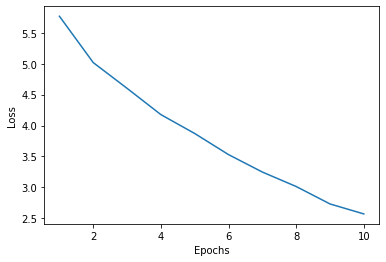

In [ ]:
ts = np.arange(1,epochs+1,1)
plt.plot(ts,losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
def greedySearch(photo, model = model):
    #photo = train_img_encoding[photo_id]
    photo  = photo[np.newaxis,...]
    in_text = '<s>'
    for i in range(max_len):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '</s>':
            break
    
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Checking if model is training properly

In [ ]:
model = tf.keras.models.load_model(model_checkpoint)

In [ ]:
sample_images = list(sample_train.keys())
photo_id = sample_images[5]
print (photo_id)

228822815.jpg


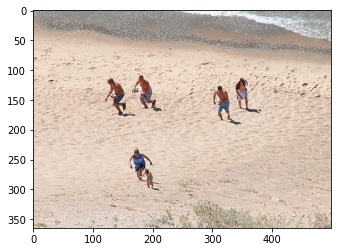

In [ ]:
from skimage.io import imread

img_path = os.path.join(wd, '228822815.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = train_img_encoding[photo_id]
greedySearch(photo)

'group of people running on the beach'

In [ ]:
greedySearch(photo, model_loaded)

'group of people running on the beach'

In [ ]:
photo_id = sample_images[49]
print (photo_id)

2937611480.jpg


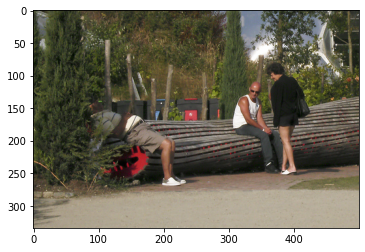

In [ ]:
img_path = os.path.join(wd, '2937611480.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = train_img_encoding[photo_id]
print  (train[photo_id])
greedySearch(photo)

['<s> three people two seated on large rolled up piece of artifcial turf and female standing talking to one of the seated men </s>', '<s> two men resting on odd shaped bench while one is talking with woman </s>', '<s> group of people sit on bench outside that looks like tree trunk </s>', '<s> man is laying back while man and woman look in his direction </s>', '<s> couple watching man sleep on piece of art </s>']


'two people sit on the other'

In [ ]:
greedySearch(photo, model_loaded)

'two people sit on the other'

In [ ]:
photo_id = sample_images[0]

print (photo_id)

17516940.jpg


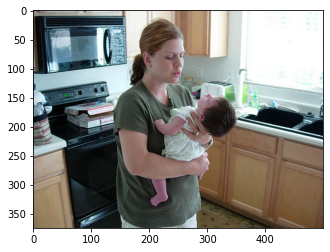

In [ ]:
img_path = os.path.join(wd, '17516940.jpg')
img = imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
photo = train_img_encoding[photo_id]
print (train[photo_id])
greedySearch(photo)

['<s> woman in sunlit kitchen is trying to comfort baby </s>', '<s> mother stands in kitchen holding small baby </s>', '<s> mother is holding her baby in the kitchen </s>', '<s> woman holding child in her hands </s>', '<s> lady holding baby in kitchen </s>']


'mother in kitchen'

#### Model evaluation 

In [ ]:
test_images = list(test.keys())
test_img = test_images[0]
test_img

'3655176735.jpg'

In [ ]:
photo = test_img_encoding[test_img]
generated_caption = greedySearch(photo)
generated_caption

'woman in maroon dress is standing on the back of the back'

In [ ]:
test_captions = test[test_img]
test_captions

['an older woman appears to read from children book in an indoor setting while seated gentleman in service uniform looks on',
 'woman with short black hair and colorful necklace reads children illustration book',
 'woman with white shirt holding children book',
 'woman reading children book',
 'lady reading story book']

In [ ]:
references = [x.split(' ') for x in test_captions]
candidate = generated_caption.split(' ')

In [ ]:
print (references)
print (candidate)

[['an', 'older', 'woman', 'appears', 'to', 'read', 'from', 'children', 'book', 'in', 'an', 'indoor', 'setting', 'while', 'seated', 'gentleman', 'in', 'service', 'uniform', 'looks', 'on'], ['woman', 'with', 'short', 'black', 'hair', 'and', 'colorful', 'necklace', 'reads', 'children', 'illustration', 'book'], ['woman', 'with', 'white', 'shirt', 'holding', 'children', 'book'], ['woman', 'reading', 'children', 'book'], ['lady', 'reading', 'story', 'book']]
['man', 'in', 'black', 'shirt', 'and', 'gray', 'hat', 'is', 'standing', 'in', 'front', 'of', 'paper']


In [ ]:
sentence_bleu(references, candidate, weights = (1,0))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.38461538461538464

In [ ]:
def bleu_scores(references, candidate):
  b1 = nltk.translate.bleu_score.sentence_bleu(references, candidate, weights = (1,0,0,0))
  b2 = nltk.translate.bleu_score.sentence_bleu(references, candidate, weights = (0.5,0.5,0,0))
  b3 = nltk.translate.bleu_score.sentence_bleu(references, candidate, weights = (0.33,0.33,0.33,0))
  b4 = nltk.translate.bleu_score.sentence_bleu(references, candidate, weights = (0.25,0.25,0.25,0.25))

  return (b1,b2,b3,b4)

In [ ]:
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
meteor_score(test_captions, generated_caption)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0.10416666666666667

In [ ]:
b1,b2,b3,b4 = bleu_scores(references, candidate)
b1,b2,b3,b4

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


(0.38461538461538464,
 0.6201736729460423,
 0.7295562715400982,
 0.7875110621102679)

**Evaluate on 200 test images**

In [ ]:
def evaluate_test(subset_size = 200):
  avg_b1 = 0
  images = list(test.keys())
  avg_meteor = 0
  for test_img in tqdm(images[:subset_size]):
    photo = test_img_encoding[test_img]
    generated_caption = greedySearch(photo)

    test_captions = test[test_img]
    meteor = meteor_score(test_captions, generated_caption)
    avg_meteor += meteor
    references = [x.split(' ') for x in test_captions]
    candidate = generated_caption.split(' ')

    b1 = sentence_bleu(references, candidate, weights = (1,0))
    avg_b1 += b1

  avg_b1/=subset_size
  avg_meteor /= subset_size
  return avg_b1, avg_meteor  

In [ ]:
b1, meteor = evaluate_test()

  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


In [ ]:
b1, meteor

(0.36490321061298686, 0.18528665430156252)